# PRE-PROCESSING

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copy all edf files to same place for easier conversion to ascii
""" source_folder = "/Users/dako/Downloads/VISCOM/all_fitts_law"  # Change this to your actual source folder path
destination_folder = "/Users/dako/Desktop/Viscom_all_participants/Fitts/fitts_edf"  # Change this to your actual destination folder path

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Iterate over subfolders and copy .edf files
for root, _, files in os.walk(source_folder):
    for file in files:
        if file.endswith(".EDF"):
            source_file = os.path.join(root, file)
            destination_file = os.path.join(destination_folder, file)
            
            # Ensure unique filenames if multiple subfolders have same file name
            if os.path.exists(destination_file):
                filename, ext = os.path.splitext(file)
                counter = 1
                while os.path.exists(os.path.join(destination_folder, f"{filename}_{counter}{ext}")):
                    counter += 1
                destination_file = os.path.join(destination_folder, f"{filename}_{counter}{ext}")

            shutil.copy2(source_file, destination_file)  # Preserve metadata
            print(f"Copied: {source_file} -> {destination_file}")

print("All .edf files have been copied successfully.") """

' source_folder = "/Users/dako/Downloads/VISCOM/all_fitts_law"  # Change this to your actual source folder path\ndestination_folder = "/Users/dako/Desktop/Viscom_all_participants/Fitts/fitts_edf"  # Change this to your actual destination folder path\n\n# Ensure the destination folder exists\nos.makedirs(destination_folder, exist_ok=True)\n\n# Iterate over subfolders and copy .edf files\nfor root, _, files in os.walk(source_folder):\n    for file in files:\n        if file.endswith(".EDF"):\n            source_file = os.path.join(root, file)\n            destination_file = os.path.join(destination_folder, file)\n            \n            # Ensure unique filenames if multiple subfolders have same file name\n            if os.path.exists(destination_file):\n                filename, ext = os.path.splitext(file)\n                counter = 1\n                while os.path.exists(os.path.join(destination_folder, f"{filename}_{counter}{ext}")):\n                    counter += 1\n             

In [2]:
# Load the participant info Excel file
file_path = "/Users/dako/Downloads/VISCOM/info (1).xlsx"  
df = pd.read_excel(file_path)

In [3]:
import os
import pandas as pd

def process_file_trials(file_path):
    """
    Process a single ASC file to extract trial events, including distance and target width for trials.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    events = []
    current_trial_id = None  # Keep track of the current trial ID

    # Parse the lines
    for line in lines:
        line = line.strip()
        parts = line.split()

        # Detect trial start marked by "TRIALID"
        if "TRIALID" in line:
            current_trial_id = int(parts[-1])  # Update current trial ID
            time = int(parts[1])  # Extract time
            events.append({
                "trial_id": current_trial_id,
                "time": time,
                "event": "TRIALID",
                "stimulus_x": None,
                "stimulus_y": None,
                "colour": None,
                "distance": None,
                "target_width": None
            })

        # Detect START line, marking the beginning of the trial
        elif line.startswith("START"):
            time = int(parts[1])  # Extract time
            events.append({
                "trial_id": current_trial_id,
                "time": time,
                "event": "START",
                "stimulus_x": None,
                "stimulus_y": None,
                "colour": None,
                "distance": None,
                "target_width": None
            })

        # Detect END line, marking the end of the trial
        elif line.startswith("END"):
            time = int(parts[1])  # Extract time
            events.append({
                "trial_id": current_trial_id,
                "time": time,
                "event": "END",
                "stimulus_x": None,
                "stimulus_y": None,
                "colour": None,
                "distance": None,
                "target_width": None
            })

        # Detect "!V TRIAL_VAR_DATA" and extract distance and target width
        elif "!V TRIAL_VAR_DATA" in line:
            try:
                time = int(parts[1])  # Extract time
                distance = float(parts[4])  # First number after "!V TRIAL_VAR_DATA"
                target_width = float(parts[5])  # Second number
            except (ValueError, IndexError):
                distance = None
                target_width = None
            events.append({
                "trial_id": current_trial_id,
                "time": time,
                "event": "TRIAL_VAR_DATA",
                "stimulus_x": None,
                "stimulus_y": None,
                "colour": None,
                "distance": distance,
                "target_width": target_width
            })

        # Detect FIXPOINT messages
        elif "FIXPOINT" in line:
            try:
                time = int(parts[1])  # Extract time
                colour = " ".join(parts[4:7])  # Extract first 3 values after FIXPOINT
                stimulus_x = float(parts[10])
                stimulus_y = float(parts[11])
            except (ValueError, IndexError):
                colour = None
                stimulus_x = None
                stimulus_y = None
            events.append({
                "trial_id": current_trial_id,
                "time": time if 'time' in locals() else None,
                "event": "FIXPOINT",
                "stimulus_x": stimulus_x,
                "stimulus_y": stimulus_y,
                "colour": colour,
                "distance": None,
                "target_width": None
            })

    # Convert events to a DataFrame
    events_df = pd.DataFrame(events)
    events_df = events_df.sort_values(by=["trial_id", "time"]).reset_index(drop=True)
    return events_df

# Process multiple files
data_directory = "/Users/dako/Desktop/Viscom_all_participants/Fitts/fitts_edf"  # Replace with your directory path
all_files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.asc')]

combined_df = pd.DataFrame()


# Process each file, extract relevant information, and concatenate results
for file_path in all_files:
    events_df = process_file_trials(file_path)
    events_df['file_name'] = os.path.basename(file_path)  # Add file identifier
    events_df['participant_id'] = events_df['file_name'].str.extract(r'FittsLaw_(\d+)_').astype(int)  # Extract participant ID
    combined_df = pd.concat([combined_df, events_df], ignore_index=True)

# Display the final DataFrame
(combined_df)

trial_id      time           event  stimulus_x  stimulus_y   colour  \
0           0.0  14147544         TRIALID         NaN         NaN     None   
1           0.0  14147556           START         NaN         NaN     None   
2           0.0  14147596  TRIAL_VAR_DATA         NaN         NaN     None   
3           0.0  14147596        FIXPOINT       794.0       540.0  255 0 0   
4           0.0  14147596        FIXPOINT      1125.0       540.0  255 0 0   
...         ...       ...             ...         ...         ...      ...   
10925       9.0   1136221           START         NaN         NaN     None   
10926       9.0   1136258  TRIAL_VAR_DATA         NaN         NaN     None   
10927       9.0   1136258        FIXPOINT      1193.0       773.0  255 0 0   
10928       9.0   1136259        FIXPOINT       726.0       306.0  255 0 0   
10929       9.0   1147362             END         NaN         NaN     None   

       distance  target_width           file_name  participant_id  
0           NaN           NaN  FittsLaw_278_0.asc             278  
1           NaN           NaN  FittsLaw_278_0.asc             278  
2          7.48          0.75  FittsLaw_278_0.asc             278  
3           NaN           NaN  FittsLaw_278_0.asc             278  
4           NaN           NaN  FittsLaw_278_0.asc             278  
...         ...           ...                 ...             ...  
10925       NaN           NaN  FittsLaw_151_1.asc             151  
10926     14.90          0.75  FittsLaw_151_1.asc             151  
10927       NaN           NaN  FittsLaw_151_1.asc             151  
10928       NaN           NaN  FittsLaw_151_1.asc             151  
10929       NaN           NaN  FittsLaw_151_1.asc             151  

[10930 rows x 10 columns]

In [4]:
# Rename values in the 'event' column
combined_df.loc[combined_df["event"] == "TRIAL_VAR_DATA", "event"] = "stimulus_onset"

trial_data = combined_df.drop(columns=['file_name'])

In [5]:
trial_data["participant_id"] = trial_data["participant_id"].astype(int)
trial_data['condition'] = trial_data['participant_id'].map(df.set_index('ID')['Group'])

In [6]:
# exlude participant 237 - the parsing of the edf file is broken and differs significantly from other participants
trial_data = trial_data[trial_data["participant_id"] != 237]
trial_data

trial_id      time           event  stimulus_x  stimulus_y   colour  \
0           0.0  14147544         TRIALID         NaN         NaN     None   
1           0.0  14147556           START         NaN         NaN     None   
2           0.0  14147596  stimulus_onset         NaN         NaN     None   
3           0.0  14147596        FIXPOINT       794.0       540.0  255 0 0   
4           0.0  14147596        FIXPOINT      1125.0       540.0  255 0 0   
...         ...       ...             ...         ...         ...      ...   
10925       9.0   1136221           START         NaN         NaN     None   
10926       9.0   1136258  stimulus_onset         NaN         NaN     None   
10927       9.0   1136258        FIXPOINT      1193.0       773.0  255 0 0   
10928       9.0   1136259        FIXPOINT       726.0       306.0  255 0 0   
10929       9.0   1147362             END         NaN         NaN     None   

       distance  target_width  participant_id condition  
0           NaN           NaN             278   PATIENT  
1           NaN           NaN             278   PATIENT  
2          7.48          0.75             278   PATIENT  
3           NaN           NaN             278   PATIENT  
4           NaN           NaN             278   PATIENT  
...         ...           ...             ...       ...  
10925       NaN           NaN             151   PATIENT  
10926     14.90          0.75             151   PATIENT  
10927       NaN           NaN             151   PATIENT  
10928       NaN           NaN             151   PATIENT  
10929       NaN           NaN             151   PATIENT  

[10848 rows x 10 columns]

In [7]:
trial_data.to_csv("fitts_law_all_trials.csv", index=False)

In [8]:
# Define the directory containing ASC files
asc_directory =  "/Users/dako/Desktop/Viscom_all_participants/Fitts/fitts_edf"

# List all ASC files in the directory
asc_files = [f for f in os.listdir(asc_directory) if f.endswith('.asc')]

# Display the files to confirm
print("Files to process:", asc_files)

Files to process: ['FittsLaw_278_0.asc', 'FittsLaw_184_0.asc', 'FittsLaw_285_0.asc', 'FittsLaw_398_0.asc', 'FittsLaw_365_0.asc', 'FittsLaw_358_0.asc', 'FittsLaw_144_0.asc', 'FittsLaw_245_0.asc', 'FittsLaw_200_0.asc', 'FittsLaw_381_1.asc', 'FittsLaw_339_0.asc', 'FittsLaw_125_0.asc', 'FittsLaw_118_0.asc', 'FittsLaw_219_0.asc', 'FittsLaw_343_0.asc', 'FittsLaw_383_0.asc', 'FittsLaw_127_0.asc', 'FittsLaw_263_0.asc', 'FittsLaw_146_0.asc', 'FittsLaw_103_0.asc', 'FittsLaw_322_0.asc', 'FittsLaw_142_0.asc', 'FittsLaw_206_0.asc', 'FittsLaw_182_0.asc', 'FittsLaw_283_0.asc', 'FittsLaw_347_0.asc', 'FittsLaw_267_0.asc', 'FittsLaw_243_1.asc', 'FittsLaw_387_0.asc', 'FittsLaw_298_0.asc', 'FittsLaw_121_0.asc', 'FittsLaw_199_0.asc', 'FittsLaw_220_0.asc', 'FittsLaw_378_0.asc', 'FittsLaw_345_0.asc', 'FittsLaw_258_0.asc', 'FittsLaw_302_2.asc', 'FittsLaw_138_0.asc', 'FittsLaw_281_0.asc', 'FittsLaw_239_0.asc', 'FittsLaw_180_0.asc', 'FittsLaw_204_0.asc', 'FittsLaw_105_0.asc', 'FittsLaw_227_0.asc', 'FittsLaw_382

In [9]:
def parse_metadata(filename):
    """
    Extract metadata (e.g., participant ID, condition) from a filename.
    Assumes filename structure: participantID_condition_XXX.asc.
    """
    # Remove the file extension
    base = os.path.splitext(filename)[0]
    
    # Split the base name into components (assuming underscores separate variables)
    parts = base.split('_')
    
    # Adjust indices according to your naming convention
    participant_id = parts[1]
    condition = parts[0] if len(parts) > 1 else 'unknown'
    
    return participant_id, condition

# Example usage
for file in asc_files:
    pid, cond = parse_metadata(file)
    print(f"File: {file} -> Participant ID: {pid}, Condition: {cond}")

File: FittsLaw_278_0.asc -> Participant ID: 278, Condition: FittsLaw
File: FittsLaw_184_0.asc -> Participant ID: 184, Condition: FittsLaw
File: FittsLaw_285_0.asc -> Participant ID: 285, Condition: FittsLaw
File: FittsLaw_398_0.asc -> Participant ID: 398, Condition: FittsLaw
File: FittsLaw_365_0.asc -> Participant ID: 365, Condition: FittsLaw
File: FittsLaw_358_0.asc -> Participant ID: 358, Condition: FittsLaw
File: FittsLaw_144_0.asc -> Participant ID: 144, Condition: FittsLaw
File: FittsLaw_245_0.asc -> Participant ID: 245, Condition: FittsLaw
File: FittsLaw_200_0.asc -> Participant ID: 200, Condition: FittsLaw
File: FittsLaw_381_1.asc -> Participant ID: 381, Condition: FittsLaw
File: FittsLaw_339_0.asc -> Participant ID: 339, Condition: FittsLaw
File: FittsLaw_125_0.asc -> Participant ID: 125, Condition: FittsLaw
File: FittsLaw_118_0.asc -> Participant ID: 118, Condition: FittsLaw
File: FittsLaw_219_0.asc -> Participant ID: 219, Condition: FittsLaw
File: FittsLaw_343_0.asc -> Partic

In [10]:
def process_file(file_path, participant_id, condition):
    """
    Process a single ASC file to extract fixations, saccades, and trials,
    including detailed trial event data like stimulus onset.
    Handles malformed lines by filling missing or invalid values with NaN.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize containers
    fixations = []
    saccades = []
    events = []
    current_trial_id = None  # Keep track of the current trial ID

    # Parse the lines
    for line in lines:
        line = line.strip()

        # Fixations
        if line.startswith("EFIX"):
            parts = line.split()
            fixations.append({
                "trial_id": current_trial_id,
                "eye": parts[1] if len(parts) > 1 else np.nan,
                "start_time": int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else np.nan,
                "end_time": int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else np.nan,
                "duration": int(parts[4]) if len(parts) > 4 and parts[4].isdigit() else np.nan,
                "x": float(parts[5]) if len(parts) > 5 and parts[5].replace('.', '', 1).isdigit() else np.nan,
                "y": float(parts[6]) if len(parts) > 6 and parts[6].replace('.', '', 1).isdigit() else np.nan,
                "avg_pupil_size": float(parts[7]) if len(parts) > 7 and parts[7].replace('.', '', 1).isdigit() else np.nan,
                "participant_id": participant_id,
                "condition": condition,
            })

        # Saccades
        elif line.startswith("ESACC"):
            parts = line.split()
            saccades.append({
                "trial_id": current_trial_id,
                "eye": parts[1] if len(parts) > 1 else np.nan,
                "start_time": int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else np.nan,
                "end_time": int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else np.nan,
                "duration": int(parts[4]) if len(parts) > 4 and parts[4].isdigit() else np.nan,
                "start_x": float(parts[5]) if len(parts) > 5 and parts[5].replace('.', '', 1).isdigit() else np.nan,
                "start_y": float(parts[6]) if len(parts) > 6 and parts[6].replace('.', '', 1).isdigit() else np.nan,
                "end_x": float(parts[7]) if len(parts) > 7 and parts[7].replace('.', '', 1).isdigit() else np.nan,
                "end_y": float(parts[8]) if len(parts) > 8 and parts[8].replace('.', '', 1).isdigit() else np.nan,
                "amplitude": float(parts[9]) if len(parts) > 9 and parts[9].replace('.', '', 1).isdigit() else np.nan,
                "peak_velocity": float(parts[10]) if len(parts) > 10 and parts[10].replace('.', '', 1).isdigit() else np.nan,
                "participant_id": participant_id,
                "condition": condition,
            })

        # Trial events
        elif "TRIALID" in line:
            current_trial_id = int(line.split()[-1])  # Update current trial ID
            time = int(line.split()[1])  # Extract time
            events.append({"trial_id": current_trial_id, "time": time, "event": "TRIALID", "colour": None, "coordinates": None})


    # Convert to DataFrames for fixations and saccades
    fixations_df = pd.DataFrame(fixations)
    saccades_df = pd.DataFrame(saccades)

    return fixations_df, saccades_df

In [11]:
fixations_list = []
saccades_list = []
trials_list = []

for file in asc_files:
    file_path = os.path.join(asc_directory, file)
    participant_id, condition = parse_metadata(file)
    
    fixations_df, saccades_df = process_file(file_path, participant_id, condition)
    
    fixations_list.append(fixations_df)
    saccades_list.append(saccades_df)
    #trials_list.append(trials_df)

# Combine all data into single DataFrames
all_fixations = pd.concat(fixations_list, ignore_index=True)
all_saccades = pd.concat(saccades_list, ignore_index=True)
#all_trials = pd.concat(trials_list, ignore_index=True)

In [12]:
filtered_fixations = all_fixations[(all_fixations["duration"] >= 110) & (all_fixations["duration"] <= 850)]
filtered_saccades = all_saccades[(all_saccades["duration"] >= 5) & (all_saccades["duration"] <= 100)]
filtered_saccades = filtered_saccades[(filtered_saccades["amplitude"] > 0.4) & (filtered_saccades["peak_velocity"] > 0)]
filtered_saccades["average_velocity"] = filtered_saccades["amplitude"] / filtered_saccades["duration"]*1000

In [13]:
filtered_fixations

trial_id eye  start_time  end_time  duration       x      y  \
0            0.0   R    14147563  14147834       271   822.5  545.1   
1            0.0   L    14147563  14147835       272   862.0  567.6   
2            0.0   L    14147887  14148171       284  1176.0  555.5   
3            0.0   R    14147885  14148172       287  1148.0  552.5   
4            0.0   L    14148210  14148609       399   979.9  560.3   
...          ...  ..         ...       ...       ...     ...    ...   
118088       9.0   R     1146171   1146409       238  1173.9  817.5   
118089       9.0   R     1146467   1146644       177   715.5  262.4   
118090       9.0   L     1146472   1146645       173   762.6  276.3   
118093       9.0   L     1147247   1147360       113   950.3  469.8   
118094       9.0   R     1147246   1147360       114   921.6  504.9   

        avg_pupil_size participant_id condition  
0               1301.0            278  FittsLaw  
1               1407.0            278  FittsLaw  
2               1398.0            278  FittsLaw  
3               1317.0            278  FittsLaw  
4               1422.0            278  FittsLaw  
...                ...            ...       ...  
118088          1147.0            151  FittsLaw  
118089          1095.0            151  FittsLaw  
118090          1220.0            151  FittsLaw  
118093          1439.0            151  FittsLaw  
118094          1350.0            151  FittsLaw  

[104472 rows x 10 columns]

In [14]:
filtered_fixations = filtered_fixations.dropna(subset=["trial_id"])
filtered_saccades = filtered_saccades.dropna(subset=["trial_id"])

In [15]:
filtered_fixations["participant_id"] = filtered_fixations["participant_id"].astype(int)
filtered_fixations["trial_id"] = filtered_fixations["trial_id"].astype(int)
filtered_saccades["participant_id"] = filtered_saccades["participant_id"].astype(int)
filtered_saccades["trial_id"] = filtered_saccades["trial_id"].astype(int)

filtered_fixations['condition'] = filtered_fixations['participant_id'].map(df.set_index('ID')['Group'])
filtered_saccades['condition'] = filtered_saccades['participant_id'].map(df.set_index('ID')['Group'])

/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_60314/534699673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fixations["participant_id"] = filtered_fixations["participant_id"].astype(int)
/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_60314/534699673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fixations["trial_id"] = filtered_fixations["trial_id"].astype(int)
/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_60314/534699673.py:6: SettingWithCo

In [16]:
filtered_fixations = filtered_fixations[filtered_fixations["participant_id"] != 237]
filtered_saccades = filtered_saccades[filtered_saccades["participant_id"] != 237]

In [17]:
filtered_fixations.to_csv("fitts_law_all_fixations.csv", index=False)
filtered_saccades.to_csv("fitts_law_all_saccades.csv", index=False)
trial_data.to_csv("fitts_law_all_trials.csv", index=False)

In [18]:
# Rename 'time' to 'start_time'
stimulus_onset_rows = trial_data[trial_data["event"] == "stimulus_onset"].copy()
stimulus_onset_rows = stimulus_onset_rows.rename(columns={"time": "start_time"})

# Find FIXPOINT coordinates for each trial
fixpoints = trial_data[trial_data["event"] == "FIXPOINT"].groupby(["participant_id", "trial_id"]).agg(
    stimulus1_x=("stimulus_x", lambda x: x.iloc[0] if len(x) > 0 else None),
    stimulus1_y=("stimulus_y", lambda x: x.iloc[0] if len(x) > 0 else None),
    stimulus2_x=("stimulus_x", lambda x: x.iloc[1] if len(x) > 1 else None),
    stimulus2_y=("stimulus_y", lambda x: x.iloc[1] if len(x) > 1 else None),
).reset_index()

# Extract end_time from 'END' events
end_times = trial_data[trial_data["event"] == "END"].copy()
end_times = end_times.rename(columns={"time": "end_time"})[["participant_id", "trial_id", "end_time"]]

# Merge fixpoints with stimulus_onset_rows
stimulus_onset_df = pd.merge(stimulus_onset_rows, fixpoints, on=["participant_id", "trial_id"], how="left")

# Merge end times into stimulus_onset_df
stimulus_onset_df = pd.merge(stimulus_onset_df, end_times, on=["participant_id", "trial_id"], how="left")

# Drop unnecessary columns
#filtered_df = filtered_df[["trial_id", "time", "event", "stimulus1_x", "stimulus1_y", "stimulus2_x", "stimulus2_y", "participant_id"]]

In [19]:
stimulus_onset_df

trial_id  start_time           event  stimulus_x  stimulus_y colour  \
0          0.0    14147596  stimulus_onset         NaN         NaN   None   
1          1.0    14161911  stimulus_onset         NaN         NaN   None   
2          2.0    14176499  stimulus_onset         NaN         NaN   None   
3          3.0    14189873  stimulus_onset         NaN         NaN   None   
4          4.0    14202890  stimulus_onset         NaN         NaN   None   
...        ...         ...             ...         ...         ...    ...   
1803       5.0     1077712  stimulus_onset         NaN         NaN   None   
1804       6.0     1092547  stimulus_onset         NaN         NaN   None   
1805       7.0     1106881  stimulus_onset         NaN         NaN   None   
1806       8.0     1121313  stimulus_onset         NaN         NaN   None   
1807       9.0     1136258  stimulus_onset         NaN         NaN   None   

      distance  target_width  participant_id condition  stimulus1_x  \
0         7.48          0.75             278   PATIENT        794.0   
1         7.48          3.48             278   PATIENT        794.0   
2        28.80         11.20             278   PATIENT        321.0   
3        25.50          0.75             278   PATIENT        394.0   
4        25.50          3.48             278   PATIENT        394.0   
...        ...           ...             ...       ...          ...   
1803     25.50         11.20             151   PATIENT        394.0   
1804     14.90          0.75             151   PATIENT        960.0   
1805     14.90          3.48             151   PATIENT        960.0   
1806     14.90          0.75             151   PATIENT        726.0   
1807     14.90          0.75             151   PATIENT       1193.0   

      stimulus1_y  stimulus2_x  stimulus2_y  end_time  
0           540.0       1125.0        540.0  14158700  
1           540.0       1125.0        540.0  14173017  
2           540.0       1598.0        540.0  14187604  
3           540.0       1525.0        540.0  14200978  
4           540.0       1525.0        540.0  14213994  
...           ...          ...          ...       ...  
1803        540.0       1525.0        540.0   1088817  
1804        870.0        960.0        209.0   1103652  
1805        870.0        960.0        209.0   1117985  
1806        773.0       1193.0        306.0   1132418  
1807        773.0        726.0        306.0   1147362  

[1808 rows x 15 columns]

In [20]:
column_order = [
    "trial_id",
    "participant_id", "start_time", "end_time", "event", "stimulus1_x", "stimulus1_y", "stimulus2_x", "stimulus2_y", "distance", "target_width"
]

# Reassign the dataframe with the new column order
stimulus_onset_df = stimulus_onset_df[column_order]
stimulus_onset_df["participant_id"] = stimulus_onset_df["participant_id"].astype(int)
stimulus_onset_df["trial_id"] = stimulus_onset_df["trial_id"].astype(int)

stimulus_onset_df['condition'] = stimulus_onset_df['participant_id'].map(df.set_index('ID')['Group'])
stimulus_onset_df

/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_60314/1546616909.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_onset_df["participant_id"] = stimulus_onset_df["participant_id"].astype(int)
/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_60314/1546616909.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_onset_df["trial_id"] = stimulus_onset_df["trial_id"].astype(int)
/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_60314/1546616909.py:11: SettingWithCo

trial_id  participant_id  start_time  end_time           event  \
0            0             278    14147596  14158700  stimulus_onset   
1            1             278    14161911  14173017  stimulus_onset   
2            2             278    14176499  14187604  stimulus_onset   
3            3             278    14189873  14200978  stimulus_onset   
4            4             278    14202890  14213994  stimulus_onset   
...        ...             ...         ...       ...             ...   
1803         5             151     1077712   1088817  stimulus_onset   
1804         6             151     1092547   1103652  stimulus_onset   
1805         7             151     1106881   1117985  stimulus_onset   
1806         8             151     1121313   1132418  stimulus_onset   
1807         9             151     1136258   1147362  stimulus_onset   

      stimulus1_x  stimulus1_y  stimulus2_x  stimulus2_y  distance  \
0           794.0        540.0       1125.0        540.0      7.48   
1           794.0        540.0       1125.0        540.0      7.48   
2           321.0        540.0       1598.0        540.0     28.80   
3           394.0        540.0       1525.0        540.0     25.50   
4           394.0        540.0       1525.0        540.0     25.50   
...           ...          ...          ...          ...       ...   
1803        394.0        540.0       1525.0        540.0     25.50   
1804        960.0        870.0        960.0        209.0     14.90   
1805        960.0        870.0        960.0        209.0     14.90   
1806        726.0        773.0       1193.0        306.0     14.90   
1807       1193.0        773.0        726.0        306.0     14.90   

      target_width condition  
0             0.75   PATIENT  
1             3.48   PATIENT  
2            11.20   PATIENT  
3             0.75   PATIENT  
4             3.48   PATIENT  
...            ...       ...  
1803         11.20   PATIENT  
1804          0.75   PATIENT  
1805          3.48   PATIENT  
1806          0.75   PATIENT  
1807          0.75   PATIENT  

[1808 rows x 12 columns]

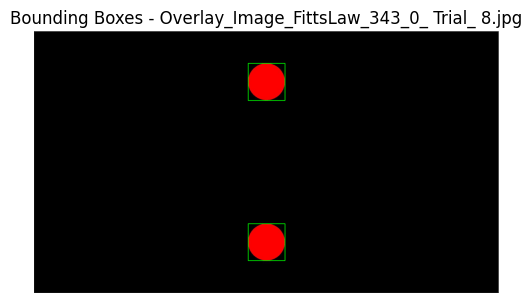

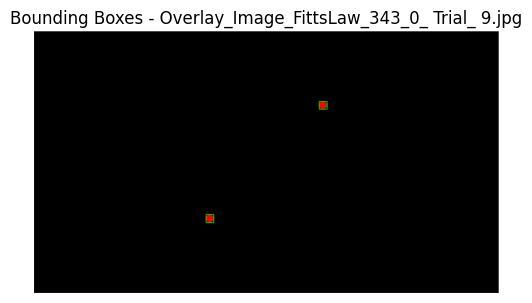

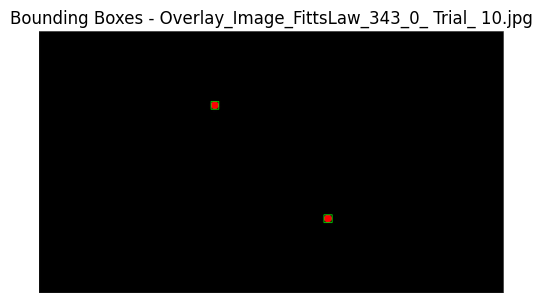

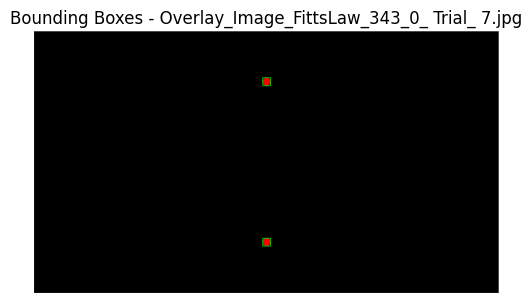

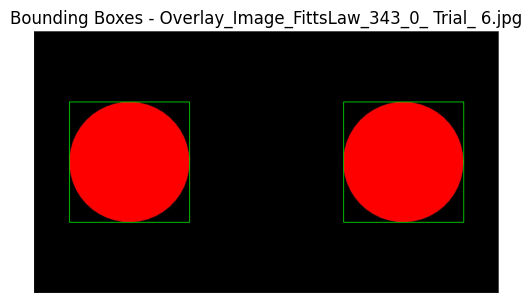

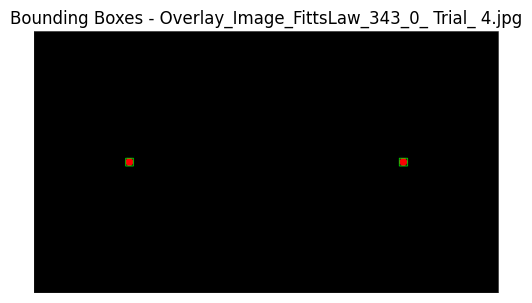

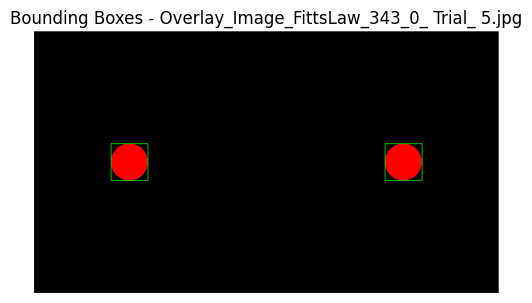

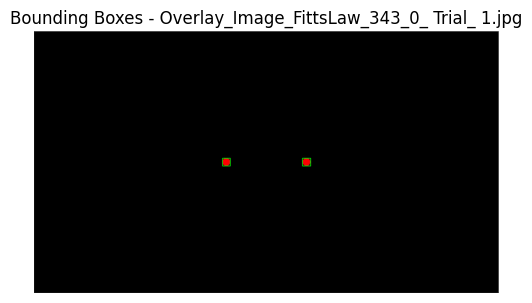

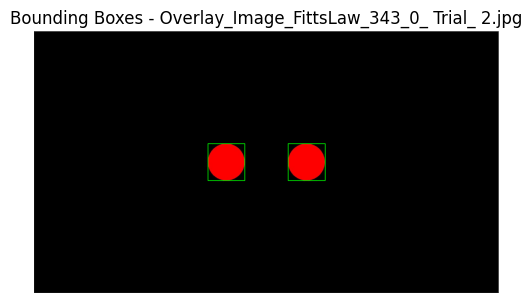

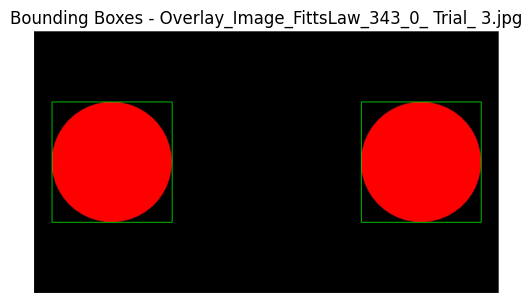

Processing complete. Images saved in: /Users/dako/Desktop/Output/


In [21]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Path to the folder containing images
image_folder = '/Users/dako/Desktop/Bounding box'
output_folder = "/Users/dako/Desktop/Output/"

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Process each image
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)

    # Convert to HSV (better for color detection)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define range for red color in HSV
    lower_red1 = np.array([0, 120, 70])   # Lower bound for red
    upper_red1 = np.array([10, 255, 255]) # Upper bound for red
    lower_red2 = np.array([170, 120, 70]) # Second range for red
    upper_red2 = np.array([180, 255, 255])

    # Create masks to detect red color
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 + mask2

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green bounding box

    # Save or display
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, image)

    # Display image with bounding boxes
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Bounding Boxes - {image_file}")
    plt.show()

print("Processing complete. Images saved in:", output_folder)

In [22]:
import cv2
import numpy as np
import os
import pandas as pd

# Path to the folder containing images
image_folder = "/Users/dako/Desktop/Bounding box"
output_csv = "bounding_boxes.csv"

# Get list of image files
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Initialize list to store bounding box coordinates
bounding_boxes = []

# Process each image
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)

    # Convert to HSV (better for color detection)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define range for red color in HSV
    lower_red1 = np.array([0, 120, 70])   # Lower bound for red
    upper_red1 = np.array([10, 255, 255]) # Upper bound for red
    lower_red2 = np.array([170, 120, 70]) # Second range for red
    upper_red2 = np.array([180, 255, 255])

    # Create masks to detect red color
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 + mask2

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Store bounding box coordinates
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)  # Get bounding box
        bounding_boxes.append([image_file, x, y, x + w, y + h])  # [image_name, start_x, start_y, end_x, end_y]

# Convert to DataFrame and save
df = pd.DataFrame(bounding_boxes, columns=["image", "start_x", "start_y", "end_x", "end_y"])
df.to_csv(output_csv, index=False)

print(f"Bounding box coordinates saved to {output_csv}")

Bounding box coordinates saved to bounding_boxes.csv


In [23]:
# Extract trial_id from the image column
df["trial_id"] = (df["image"].str.extract(r'Trial_\s*(\d+)').astype(int))-1
# Load the dataset (assuming it's already in a DataFrame format)
df["stimulus_center_x"] = (df["start_x"] + df["end_x"]) / 2
df["stimulus_center_y"] = (df["start_y"] + df["end_y"]) / 2
# Ensure that stimulus_center_x and stimulus_center_y have ".0" instead of ".5"
df["stimulus_center_x"] = df["stimulus_center_x"].apply(lambda x: float(int(x)) if x % 1 == 0.5 else x)
df["stimulus_center_y"] = df["stimulus_center_y"].apply(lambda x: float(int(x)) if x % 1 == 0.5 else x)
df = df.sort_values(by=["trial_id"]).reset_index(drop=True)

In [24]:
stimulus_onset_df = stimulus_onset_df[~stimulus_onset_df["trial_id"].isin([10, 11])]
stimulus_onset_df = stimulus_onset_df[stimulus_onset_df["participant_id"] != 237]

In [25]:
# Define the mapping of exact values for each trial_id
trial_data_map = {
    0: [778, 524, 810, 556, 1108, 524, 1142, 556],
    1: [718, 464, 870, 616, 1049, 464, 1202, 616],
    2: [74, 292, 570, 788, 1351, 292, 1846, 788],
    3: [378, 524, 410, 556, 1508, 524, 1542, 556],
    4: [318, 464, 470, 616, 1449, 464, 1602, 616],
    5: [146, 292, 642, 788, 1278, 292, 1774, 788],
    6: [944, 854, 976, 886, 944, 192, 976, 225],
    7: [884, 794, 1036, 946, 884, 133, 1036, 286],
    8: [710, 756, 742, 790, 1177, 290, 1210, 322],
    9: [1176, 757, 1210, 789, 710, 290, 742, 322],
}

# Assign new columns based on trial_id
stimulus_onset_df['stimulus1_start_x'] = stimulus_onset_df['trial_id'].map(lambda x: trial_data_map[x][0])
stimulus_onset_df['stimulus1_start_y'] = stimulus_onset_df['trial_id'].map(lambda x: trial_data_map[x][1])
stimulus_onset_df['stimulus1_end_x'] = stimulus_onset_df['trial_id'].map(lambda x: trial_data_map[x][2])
stimulus_onset_df['stimulus1_end_y'] = stimulus_onset_df['trial_id'].map(lambda x: trial_data_map[x][3])
stimulus_onset_df['stimulus2_start_x'] = stimulus_onset_df['trial_id'].map(lambda x: trial_data_map[x][4])
stimulus_onset_df['stimulus2_start_y'] = stimulus_onset_df['trial_id'].map(lambda x: trial_data_map[x][5])
stimulus_onset_df['stimulus2_end_x'] = stimulus_onset_df['trial_id'].map(lambda x: trial_data_map[x][6])
stimulus_onset_df['stimulus2_end_y'] = stimulus_onset_df['trial_id'].map(lambda x: trial_data_map[x][7])
#stimulus_onset_df = stimulus_onset_df.drop(columns=['stimulus_x', 'stimulus_y', 'colour'])

In [26]:
stimulus_onset_df.rename(columns={"start_time": "stimulus_start_time", "end_time": "stimulus_end_time"}, inplace=True)
stimulus_onset_df

trial_id  participant_id  stimulus_start_time  stimulus_end_time  \
0            0             278             14147596           14158700   
1            1             278             14161911           14173017   
2            2             278             14176499           14187604   
3            3             278             14189873           14200978   
4            4             278             14202890           14213994   
...        ...             ...                  ...                ...   
1803         5             151              1077712            1088817   
1804         6             151              1092547            1103652   
1805         7             151              1106881            1117985   
1806         8             151              1121313            1132418   
1807         9             151              1136258            1147362   

               event  stimulus1_x  stimulus1_y  stimulus2_x  stimulus2_y  \
0     stimulus_onset        794.0        540.0       1125.0        540.0   
1     stimulus_onset        794.0        540.0       1125.0        540.0   
2     stimulus_onset        321.0        540.0       1598.0        540.0   
3     stimulus_onset        394.0        540.0       1525.0        540.0   
4     stimulus_onset        394.0        540.0       1525.0        540.0   
...              ...          ...          ...          ...          ...   
1803  stimulus_onset        394.0        540.0       1525.0        540.0   
1804  stimulus_onset        960.0        870.0        960.0        209.0   
1805  stimulus_onset        960.0        870.0        960.0        209.0   
1806  stimulus_onset        726.0        773.0       1193.0        306.0   
1807  stimulus_onset       1193.0        773.0        726.0        306.0   

      distance  target_width condition  stimulus1_start_x  stimulus1_start_y  \
0         7.48          0.75   PATIENT                778                524   
1         7.48          3.48   PATIENT                718                464   
2        28.80         11.20   PATIENT                 74                292   
3        25.50          0.75   PATIENT                378                524   
4        25.50          3.48   PATIENT                318                464   
...        ...           ...       ...                ...                ...   
1803     25.50         11.20   PATIENT                146                292   
1804     14.90          0.75   PATIENT                944                854   
1805     14.90          3.48   PATIENT                884                794   
1806     14.90          0.75   PATIENT                710                756   
1807     14.90          0.75   PATIENT               1176                757   

      stimulus1_end_x  stimulus1_end_y  stimulus2_start_x  stimulus2_start_y  \
0                 810              556               1108                524   
1                 870              616               1049                464   
2                 570              788               1351                292   
3                 410              556               1508                524   
4                 470              616               1449                464   
...               ...              ...                ...                ...   
1803              642              788               1278                292   
1804              976              886                944                192   
1805             1036              946                884                133   
1806              742              790               1177                290   
1807             1210              789                710                290   

      stimulus2_end_x  stimulus2_end_y  
0                1142              556  
1                1202              616  
2                1846              788  
3                1542              556  
4                1602              616  
...               ...              .

In [27]:
saccades_with_stim = pd.merge(filtered_saccades, stimulus_onset_df, on=["trial_id", "participant_id"], how="left")
cols = list(saccades_with_stim.columns)
cols.insert(1, cols.pop(cols.index("participant_id")))
saccades_with_stim = saccades_with_stim[cols]

# Rename columns
saccades_with_stim = saccades_with_stim.rename(columns={
    "stimulus1_x": "stimulus1_center_x",
    "stimulus1_y": "stimulus1_center_y",
    "stimulus2_x": "stimulus2_center_x",
    "stimulus2_y": "stimulus2_center_y"
})

# Filter data based on time constraints
filtered_saccades_final = saccades_with_stim[
    (saccades_with_stim["start_time"] >= saccades_with_stim["stimulus_start_time"]) &
    (saccades_with_stim["end_time"] <= saccades_with_stim["stimulus_end_time"])
]
filtered_saccades_final

trial_id  participant_id eye  start_time  end_time  duration  start_x  \
0             0             278   R    14147835  14147884        49    827.5   
1             0             278   L    14147836  14147886        50    857.7   
2             0             278   L    14148172  14148209        37   1175.6   
3             0             278   R    14148173  14148212        39   1151.4   
4             0             278   L    14148610  14148638        28    975.4   
...         ...             ...  ..         ...       ...       ...      ...   
99186         9             151   R     1145914   1145966        52    670.0   
99187         9             151   L     1146156   1146170        14   1213.3   
99188         9             151   R     1146154   1146170        16   1171.3   
99189         9             151   R     1146410   1146466        56   1175.1   
99190         9             151   L     1146408   1146471        63   1222.5   

       start_y   end_x  end_y  ...  target_width  condition_y  \
0        552.5  1127.1  548.7  ...          0.75      PATIENT   
1        568.0  1153.3  550.8  ...          0.75      PATIENT   
2        561.9   996.3  569.2  ...          0.75      PATIENT   
3        555.6   970.5  550.9  ...          0.75      PATIENT   
4        553.9   821.6  550.8  ...          0.75      PATIENT   
...        ...     ...    ...  ...           ...          ...   
99186    315.1  1206.5  781.3  ...          0.75      PATIENT   
99187    761.0  1223.9  817.2  ...          0.75      PATIENT   
99188    774.2  1177.6  839.5  ...          0.75      PATIENT   
99189    810.2   727.7  267.2  ...          0.75      PATIENT   
99190    796.0   763.1  276.2  ...          0.75      PATIENT   

      stimulus1_start_x  stimulus1_start_y  stimulus1_end_x  stimulus1_end_y  \
0                 778.0              524.0            810.0            556.0   
1                 778.0              524.0            810.0            556.0   
2                 778.0              524.0            810.0            556.0   
3                 778.0              524.0            810.0            556.0   
4                 778.0              524.0            810.0            556.0   
...                 ...                ...              ...              ...   
99186            1176.0              757.0           1210.0            789.0   
99187            1176.0              757.0           1210.0            789.0   
99188            1176.0              757.0           1210.0            789.0   
99189            1176.0              757.0           1210.0            789.0   
99190            1176.0              757.0           1210.0            789.0   

      stimulus2_start_x  stimulus2_start_y  stimulus2_end_x  stimulus2_end_y  
0                1108.0              524.0           1142.0            556.0  
1                1108.0              524.0           1142.0            556.0  
2                1108.0              524.0           1142.0            556.0  
3                1108.0              524.0           1142.0            556.0  
4                1108.0              524.0           1142.0            556.0  
...                 ...                ...              ...              ...  
99186             710.0              290.0            742.0            322.0  
99187             710.0              290.0            742.0            322.0  
99188             710.0              290.0            742.0            322.0  
99189             710.0              290.0            742.0            322.0  
99190             710.0              290.0            742.0            322.0  

[98899 rows x 32 columns]

In [28]:
filtered_fixations["trial_id"] = filtered_fixations["trial_id"].astype(int)
filtered_fixations["participant_id"] = filtered_fixations["participant_id"].astype(int)
fixations_with_stim = pd.merge(filtered_fixations, stimulus_onset_df, on=["trial_id", "participant_id"], how="left")
cols = list(fixations_with_stim.columns)
cols.insert(1, cols.pop(cols.index("participant_id")))
fixations_with_stim = fixations_with_stim[cols]

# Rename columns
fixations_with_stim = fixations_with_stim.rename(columns={
    "stimulus1_x": "stimulus1_center_x",
    "stimulus1_y": "stimulus1_center_y",
    "stimulus2_x": "stimulus2_center_x",
    "stimulus2_y": "stimulus2_center_y"
})

# Filter data based on time constraints
filtered_fixations_final = fixations_with_stim[
    (fixations_with_stim["start_time"] >= fixations_with_stim["stimulus_start_time"]) &
    (fixations_with_stim["end_time"] <= fixations_with_stim["stimulus_end_time"])
]
filtered_fixations_final

trial_id  participant_id eye  start_time  end_time  duration       x  \
2              0             278   L    14147887  14148171       284  1176.0   
3              0             278   R    14147885  14148172       287  1148.0   
4              0             278   L    14148210  14148609       399   979.9   
5              0             278   R    14148213  14148610       397   958.1   
6              0             278   R    14148640  14148883       243   822.8   
...          ...             ...  ..         ...       ...       ...     ...   
103634         9             151   R     1146171   1146409       238  1173.9   
103635         9             151   R     1146467   1146644       177   715.5   
103636         9             151   L     1146472   1146645       173   762.6   
103637         9             151   L     1147247   1147360       113   950.3   
103638         9             151   R     1147246   1147360       114   921.6   

            y  avg_pupil_size condition_x  ...  target_width  condition_y  \
2       555.5          1398.0     PATIENT  ...          0.75      PATIENT   
3       552.5          1317.0     PATIENT  ...          0.75      PATIENT   
4       560.3          1422.0     PATIENT  ...          0.75      PATIENT   
5       548.5          1323.0     PATIENT  ...          0.75      PATIENT   
6       530.2          1334.0     PATIENT  ...          0.75      PATIENT   
...       ...             ...         ...  ...           ...          ...   
103634  817.5          1147.0     PATIENT  ...          0.75      PATIENT   
103635  262.4          1095.0     PATIENT  ...          0.75      PATIENT   
103636  276.3          1220.0     PATIENT  ...          0.75      PATIENT   
103637  469.8          1439.0     PATIENT  ...          0.75      PATIENT   
103638  504.9          1350.0     PATIENT  ...          0.75      PATIENT   

       stimulus1_start_x  stimulus1_start_y  stimulus1_end_x  stimulus1_end_y  \
2                  778.0              524.0            810.0            556.0   
3                  778.0              524.0            810.0            556.0   
4                  778.0              524.0            810.0            556.0   
5                  778.0              524.0            810.0            556.0   
6                  778.0              524.0            810.0            556.0   
...                  ...                ...              ...              ...   
103634            1176.0              757.0           1210.0            789.0   
103635            1176.0              757.0           1210.0            789.0   
103636            1176.0              757.0           1210.0            789.0   
103637            1176.0              757.0           1210.0            789.0   
103638            1176.0              757.0           1210.0            789.0   

        stimulus2_start_x  stimulus2_start_y  stimulus2_end_x stimulus2_end_y  
2                  1108.0              524.0           1142.0           556.0  
3                  1108.0              524.0           1142.0           556.0  
4                  1108.0              524.0           1142.0           556.0  
5                  1108.0              524.0           1142.0           556.0  
6                  1108.0              524.0           1142.0           556.0  
...                   ...                ...              ...             ...  
103634              710.0              290.0            742.0           322.0  
103635              710.0              290.0            742.0           322.0  
103636              710.0              290.0            742.0           322.0  
103637              710.0              290.0            742.0           322.0  
103638              710.0              290.0            742.0           322.0  

[100289 rows x 28 columns]

In [29]:
filtered_fixations_final.to_csv("fitts_law_fixations_with_stim.csv", index=False)
filtered_saccades_final.to_csv("fitts_law_saccades_with_stim.csv", index=False)

# ANALYSIS

In [30]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
saccades_fitts = pd.read_csv("/Users/dako/Desktop/Viscom_all_participants/Fitts/fitts_law_all_saccades.csv")
fixations_fitts = pd.read_csv("/Users/dako/Desktop/Viscom_all_participants/Fitts/fitts_law_all_fixations.csv")
trial_data_fitts = pd.read_csv("/Users/dako/Desktop/Viscom_all_participants/Fitts/fitts_law_all_trials.csv")

In [32]:
unique_trials_per_participant = trial_data_fitts.groupby("participant_id")["trial_id"].nunique()
print(unique_trials_per_participant.to_string()) # participant 87,89,96,103 had a different trial structure than the rest

participant_id
87     12
89     12
96     12
103    12
105    10
106    10
109    10
111    10
113    10
117    10
118    10
119    10
120    10
121    10
122    10
125    10
127    10
128    10
133    10
134    10
135    10
137    10
138    10
141    10
142    10
143    10
144    10
146    10
147    10
149    10
150    10
151    10
152    10
153    10
156    10
157    10
169    10
171    10
173    10
180    10
182    10
184    10
185    10
187    10
190    10
195    10
196    10
198    10
199    10
200    10
204    10
206    10
207    10
209    10
210    10
214    10
215    10
217    10
218    10
219    10
220    10
221    10
223    10
225    10
227    10
228    10
229    10
230    10
231    10
232    10
234    10
236    10
239    10
243    10
244    10
245    10
250    10
251    10
252    10
253    10
254    10
255    10
256    10
257    10
258    10
259    10
263    10
264    10
267    10
268    10
270    10
272    10
273    10
275    10
278    10
279    10
280    10
281    10
282  

In [33]:
excluded_participants = [87, 89, 96, 103]

saccades_fitts = saccades_fitts[~saccades_fitts["participant_id"].isin(excluded_participants)]
fixations_fitts = fixations_fitts[~fixations_fitts["participant_id"].isin(excluded_participants)]

In [34]:
saccades_eye_counts = saccades_fitts["eye"].value_counts() # R > L
fixations_eye_counts = fixations_fitts["eye"].value_counts() # R > L
print(saccades_eye_counts)
print(fixations_eye_counts) # only use right eye

R    49204
L    48610
Name: eye, dtype: int64
R    51385
L    50805
Name: eye, dtype: int64


In [35]:
saccades_fitts_right = saccades_fitts[saccades_fitts["eye"] == "R"]
fixations_fitts_right = fixations_fitts[fixations_fitts["eye"] == "R"]

In [36]:
# Sort the datasets by participant_id and trial_id
saccades_fitts_right = saccades_fitts_right.sort_values(by=["participant_id", "trial_id"]).reset_index(drop=True)
fixations_fitts_right = fixations_fitts_right.sort_values(by=["participant_id", "trial_id"]).reset_index(drop=True)

In [37]:
# Function to standardize time per participant
def standardize_time(df):
    df = df.sort_values(by=["participant_id", "trial_id", "start_time"]).copy()
    
    # Get the first start_time for each participant
    first_start_times = df.groupby("participant_id")["start_time"].transform("min")
    
    # Create a standardized time column
    df["standard_time"] = df["start_time"] - first_start_times
    
    return df

# Apply to saccades and fixations datasets
saccades_fitts_right_standardized = standardize_time(saccades_fitts_right)
fixations_fitts_right_standardized = standardize_time(fixations_fitts_right)

In [38]:
print(fixations_fitts_right_standardized.to_string())

       trial_id eye  start_time  end_time  duration       x       y  avg_pupil_size  participant_id condition  standard_time
0             0   R    15369439  15369549       110   802.7   493.1          1861.0             105   PATIENT              0
1             0   R    15369598  15370029       431  1115.6   487.1          2119.0             105   PATIENT            159
2             0   R    15370084  15370212       128   835.3   462.3          2231.0             105   PATIENT            645
3             0   R    15370243  15370703       460   775.3   492.0          2160.0             105   PATIENT            804
4             0   R    15370757  15371493       736  1114.0   497.9          2096.0             105   PATIENT           1318
5             0   R    15371545  15371659       114   797.0   522.4          1903.0             105   PATIENT           2106
6             0   R    15371675  15371871       196   809.2   510.2          1978.0             105   PATIENT           2236


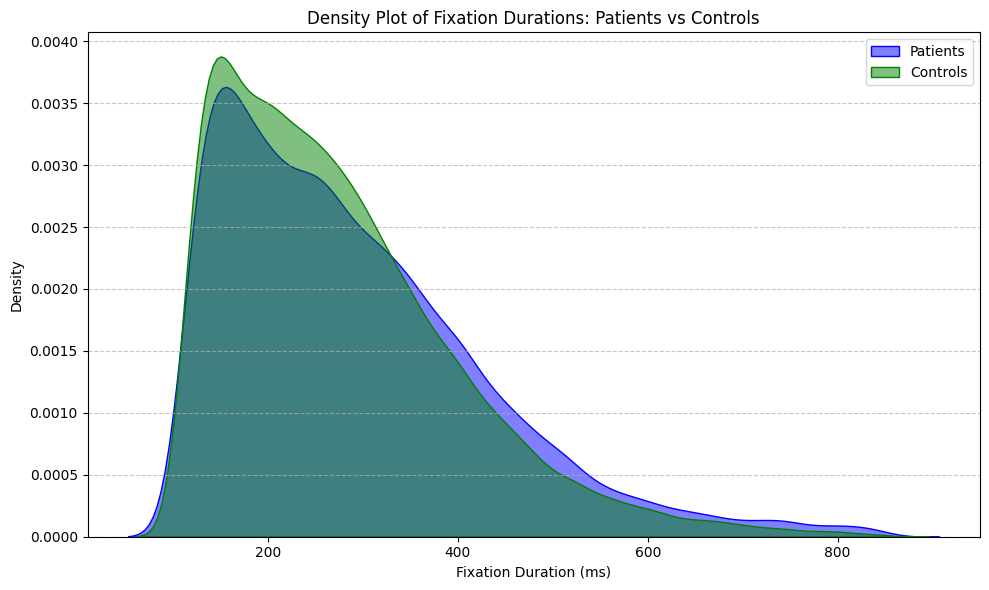

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into Patients and Controls
fixations_patient = fixations_fitts_right[fixations_fitts_right["condition"] == "PATIENT"]
fixations_control = fixations_fitts_right[fixations_fitts_right["condition"] == "CONTROL"]

# Plot combined density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(fixations_patient["duration"], fill=True, color="blue", alpha=0.5, label="Patients")
sns.kdeplot(fixations_control["duration"], fill=True, color="green", alpha=0.5, label="Controls")

plt.xlabel("Fixation Duration (ms)")
plt.ylabel("Density")
plt.title("Density Plot of Fixation Durations: Patients vs Controls")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

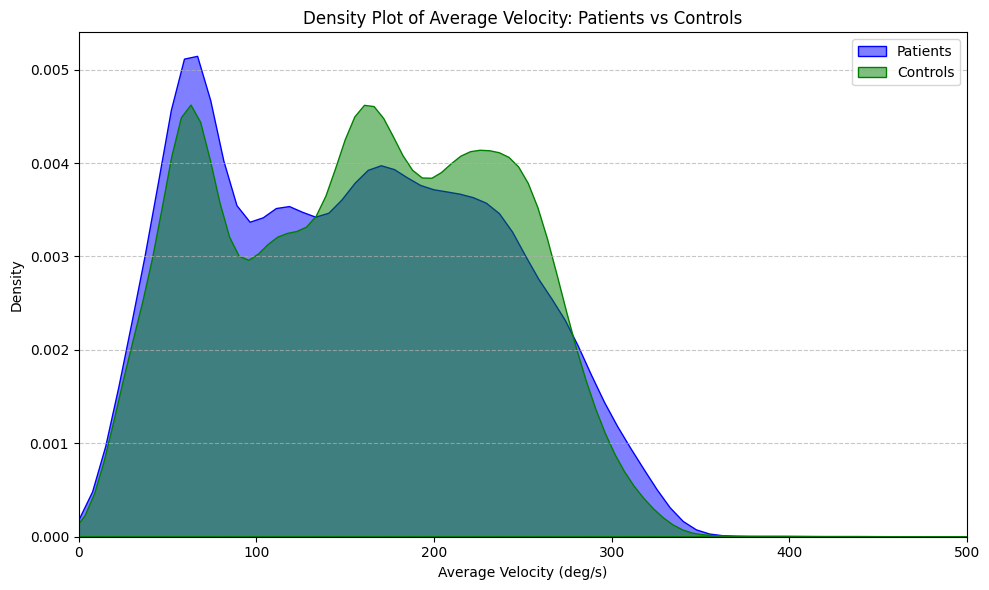

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into Patients and Controls
saccades_patient = saccades_fitts_right[saccades_fitts_right["condition"] == "PATIENT"]
saccades_control = saccades_fitts_right[saccades_fitts_right["condition"] == "CONTROL"]

# Plot combined density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(saccades_patient["average_velocity"], fill=True, color="blue", alpha=0.5, label="Patients")
sns.kdeplot(saccades_control["average_velocity"], fill=True, color="green", alpha=0.5, label="Controls")

plt.xlabel("Average Velocity (deg/s)")
plt.ylabel("Density")
plt.title("Density Plot of Average Velocity: Patients vs Controls")
plt.xlim(0, 500)  # Limit x-axis to 500
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

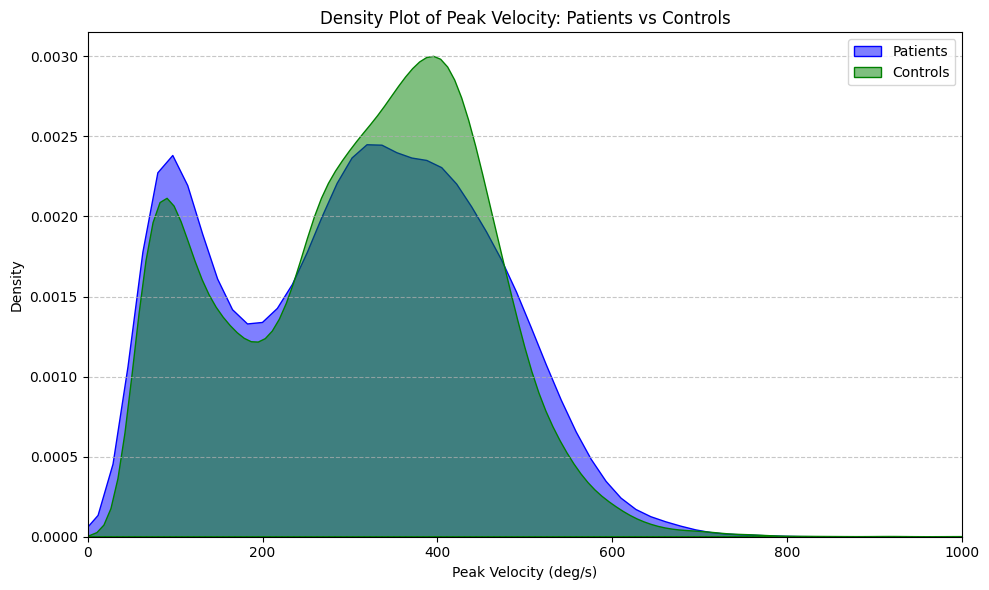

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into Patients and Controls
saccades_patient = saccades_fitts_right[saccades_fitts_right["condition"] == "PATIENT"]
saccades_control = saccades_fitts_right[saccades_fitts_right["condition"] == "CONTROL"]

# Plot combined density plot for Peak Velocity
plt.figure(figsize=(10, 6))
sns.kdeplot(saccades_patient["peak_velocity"], fill=True, color="blue", alpha=0.5, label="Patients")
sns.kdeplot(saccades_control["peak_velocity"], fill=True, color="green", alpha=0.5, label="Controls")

plt.xlabel("Peak Velocity (deg/s)")
plt.ylabel("Density")
plt.title("Density Plot of Peak Velocity: Patients vs Controls")
plt.xlim(0, 1000)  # Limit x-axis to 500
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

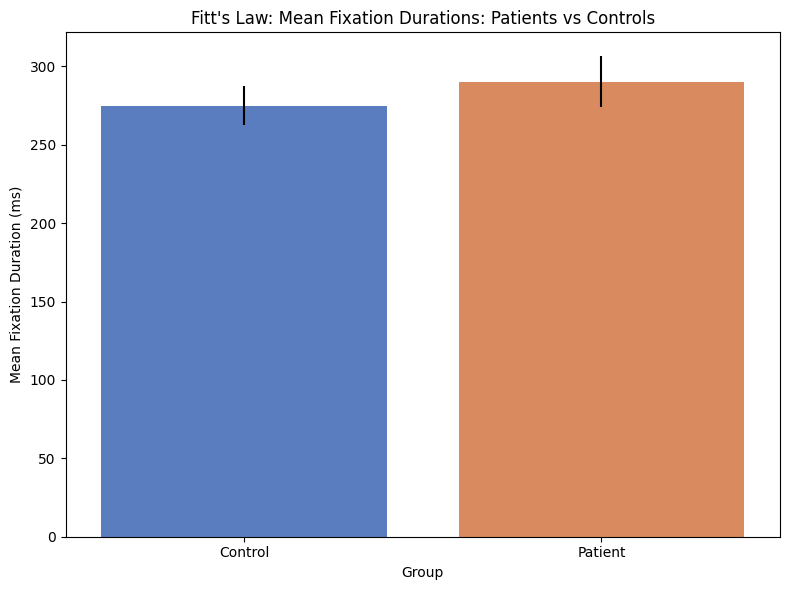

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to summarize fixation durations
def summarize_fixation_durations(df, label):
    n = len(np.unique(df["participant_id"]))  # Number of unique participants
    mean_duration = df["duration"].mean()
    sd = np.std(df["duration"], ddof=1)
    se_duration = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_duration": mean_duration, "sd": sd, "se_duration": se_duration}

# Summarize fixation durations for controls and patients
fixation_summary = pd.DataFrame([
    summarize_fixation_durations(fixations_control, "Control"),
    summarize_fixation_durations(fixations_patient, "Patient"),
])

# Plot the bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=fixation_summary, 
    x="group", 
    y="mean_duration", 
    yerr=fixation_summary["se_duration"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Fitt's Law: Mean Fixation Durations: Patients vs Controls")
plt.ylabel("Mean Fixation Duration (ms)")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

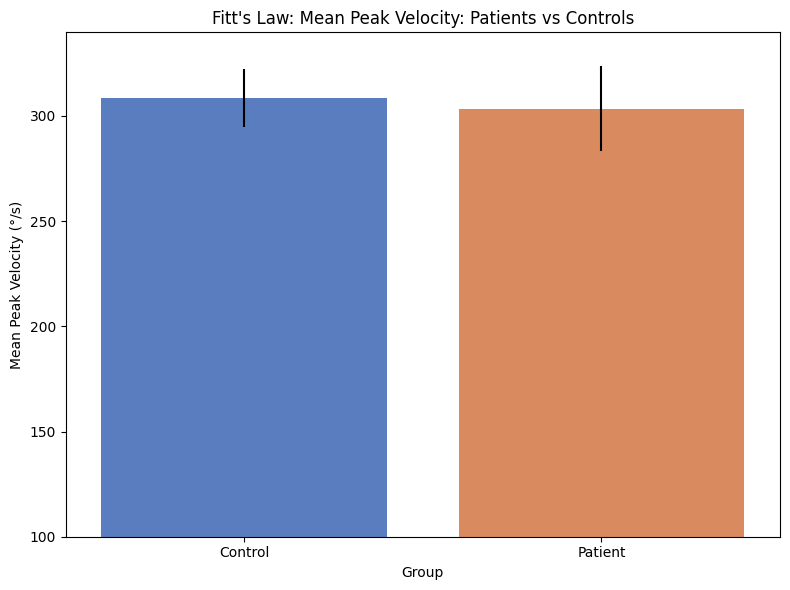

In [43]:
# Function to summarize peak velocity
def summarize_peak_velocity(df, label):
    n = len(np.unique(df["participant_id"]))  # Number of unique participants
    mean_velocity = df["peak_velocity"].mean()
    sd = np.std(df["peak_velocity"], ddof=1)
    se_velocity = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_velocity": mean_velocity, "sd": sd, "se_velocity": se_velocity}

# Summarize peak velocity for controls and patients
velocity_summary = pd.DataFrame([
    summarize_peak_velocity(saccades_control, "Control"),
    summarize_peak_velocity(saccades_patient, "Patient"),
])

# Plot the bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=velocity_summary, 
    x="group", 
    y="mean_velocity", 
    yerr=velocity_summary["se_velocity"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Fitt's Law: Mean Peak Velocity: Patients vs Controls")
plt.ylabel("Mean Peak Velocity (°/s)")
plt.xlabel("Group")
plt.ylim(100, None)  # Set y-axis to start at 100
plt.tight_layout()
plt.show()

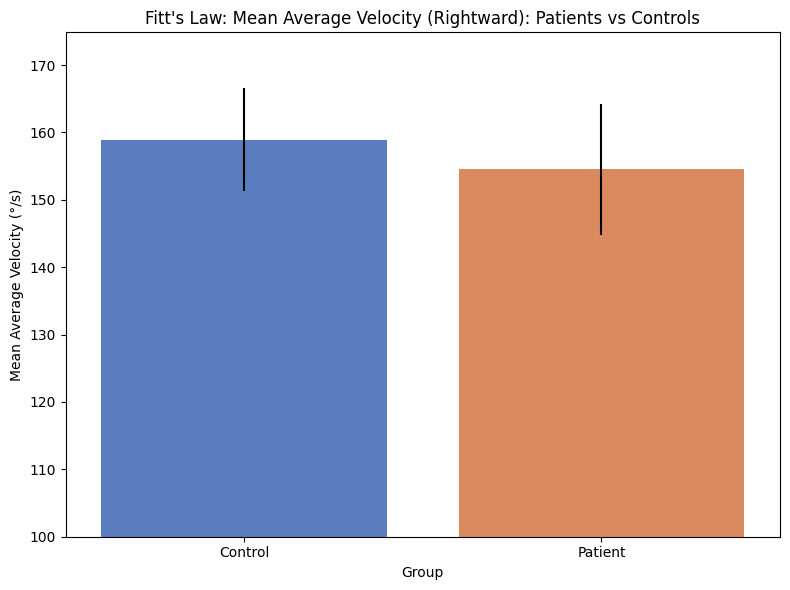

In [44]:
# Function to summarize average velocity
def summarize_average_velocity(df, label):
    n = len(np.unique(df["participant_id"]))  # Number of unique participants
    mean_velocity = df["average_velocity"].mean()
    sd = np.std(df["average_velocity"], ddof=1)
    se_velocity = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_velocity": mean_velocity, "sd": sd, "se_velocity": se_velocity}

# Summarize average velocity for controls and patients
avg_velocity_summary = pd.DataFrame([
    summarize_average_velocity(saccades_control, "Control"),
    summarize_average_velocity(saccades_patient, "Patient"),
])

# Plot the bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=avg_velocity_summary, 
    x="group", 
    y="mean_velocity", 
    yerr=avg_velocity_summary["se_velocity"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Fitt's Law: Mean Average Velocity (Rightward): Patients vs Controls")
plt.ylabel("Mean Average Velocity (°/s)")
plt.xlabel("Group")
plt.ylim(100, None)  # Set y-axis to start at 100
plt.tight_layout()
plt.show()

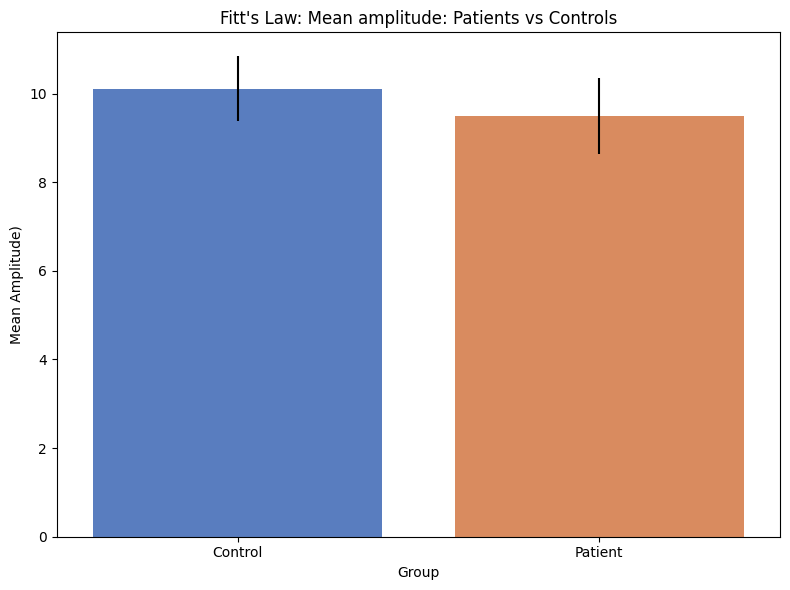

In [45]:
# Function to summarize average velocity
def summarize_amplitude(df, label, n=40):
    amplitude = df["amplitude"].mean()
    sd = np.std(df["amplitude"], ddof=1)
    se_velocity = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "amplitude": amplitude, "sd": sd, "se_velocity": se_velocity}

# Summarize average velocity for controls and patients
avg_velocity_summary = pd.DataFrame([
    summarize_amplitude(saccades_control, "Control", n=len(np.unique(saccades_control["participant_id"]))),
    summarize_amplitude(saccades_patient, "Patient", n=len(np.unique(saccades_patient["participant_id"]))),
])

# Plot the bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=avg_velocity_summary, 
    x="group", 
    y="amplitude", 
    yerr=avg_velocity_summary["se_velocity"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Fitt's Law: Mean amplitude: Patients vs Controls")
plt.ylabel("Mean Amplitude)")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

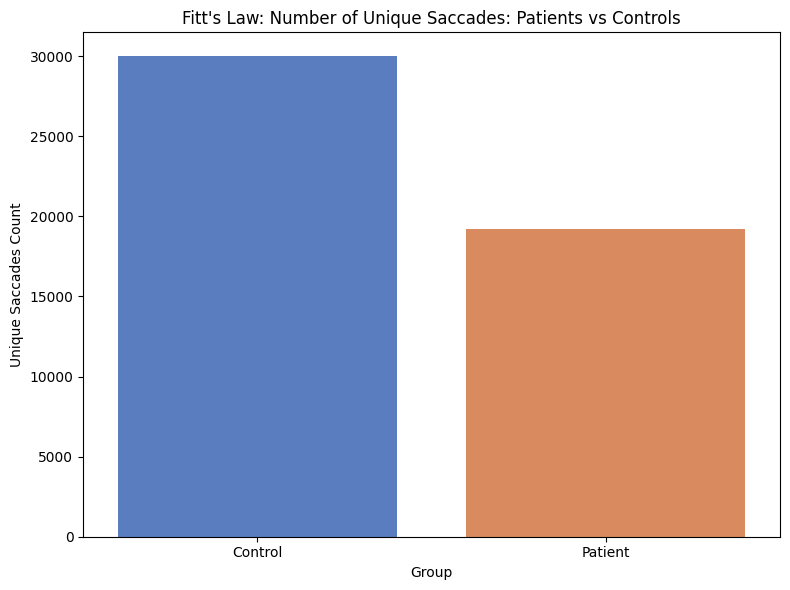

In [46]:
# Function to count the number of unique saccades
def count_unique_saccades(df, label, n=40):
    count = len(df)  # Each row represents a unique saccade
    return {"group": label, "unique_saccades": count}

# Summarize saccade counts for controls and patients
saccade_count_summary = pd.DataFrame([
    count_unique_saccades(saccades_control, "Control", n=len(np.unique(saccades_control["participant_id"]))),
    count_unique_saccades(saccades_patient, "Patient", n=len(np.unique(saccades_patient["participant_id"]))),
])

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(
    data=saccade_count_summary, 
    x="group", 
    y="unique_saccades", 
    palette="muted"
)
plt.title("Fitt's Law: Number of Unique Saccades: Patients vs Controls")
plt.ylabel("Unique Saccades Count")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

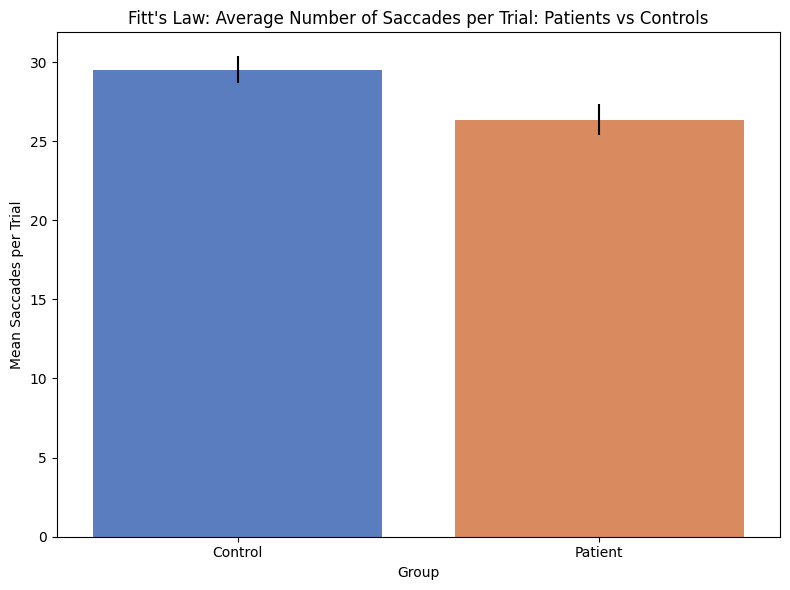

In [47]:
# Function to calculate the average number of saccades per trial
def avg_saccades_per_trial(df, label, n=40):
    saccades_per_trial = df.groupby(["participant_id", "trial_id"]).size()
    mean_saccades = saccades_per_trial.mean()
    sd_saccades = saccades_per_trial.std(ddof=1)
    se_saccades = sd_saccades / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_saccades": mean_saccades, "sd": sd_saccades, "se_saccades": se_saccades}

# Summarize the average number of saccades per trial for controls and patients
saccades_per_trial_summary = pd.DataFrame([
    avg_saccades_per_trial(saccades_control, "Control", n=len(np.unique(saccades_control["participant_id"]))),
    avg_saccades_per_trial(saccades_patient, "Patient", n=len(np.unique(saccades_patient["participant_id"]))),
])

# Plot the bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=saccades_per_trial_summary, 
    x="group", 
    y="mean_saccades", 
    yerr=saccades_per_trial_summary["se_saccades"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Fitt's Law: Average Number of Saccades per Trial: Patients vs Controls")
plt.ylabel("Mean Saccades per Trial")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

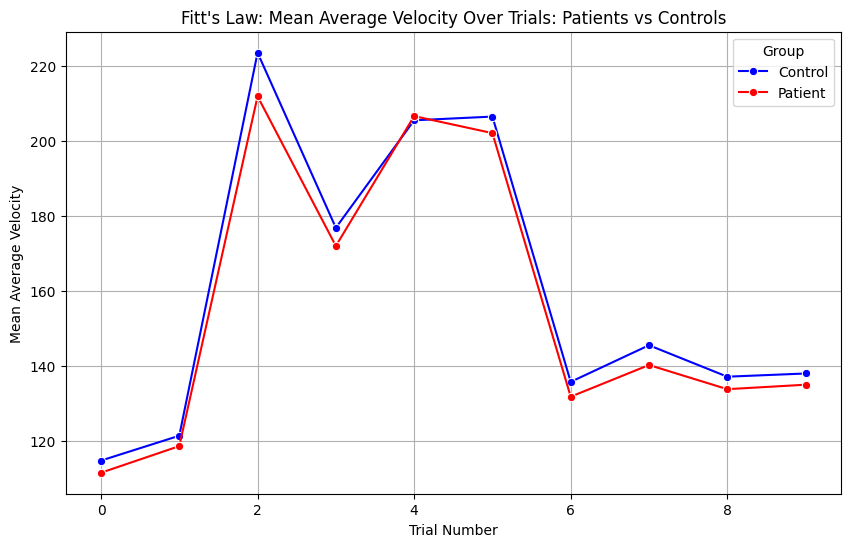

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the mean velocity per trial for each group
control_mean_velocity = saccades_control.groupby("trial_id")["average_velocity"].mean().reset_index()
patient_mean_velocity = saccades_patient.groupby("trial_id")["average_velocity"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plot controls
sns.lineplot(
    data=control_mean_velocity, 
    x="trial_id", 
    y="average_velocity", 
    label="Control", 
    linestyle="-", 
    marker="o", 
    color="blue"
)

# Plot patients
sns.lineplot(
    data=patient_mean_velocity, 
    x="trial_id", 
    y="average_velocity", 
    label="Patient", 
    linestyle="-", 
    marker="o", 
    color="red"
)

# Labels and title
plt.xlabel("Trial Number")
plt.ylabel("Mean Average Velocity")
plt.title("Fitt's Law: Mean Average Velocity Over Trials: Patients vs Controls")
plt.legend(title="Group")
#plt.xlim(0,9)  # Set y-axis to start at 100
plt.grid(True)

# Show plot
plt.show()
# Show plot
plt.show()

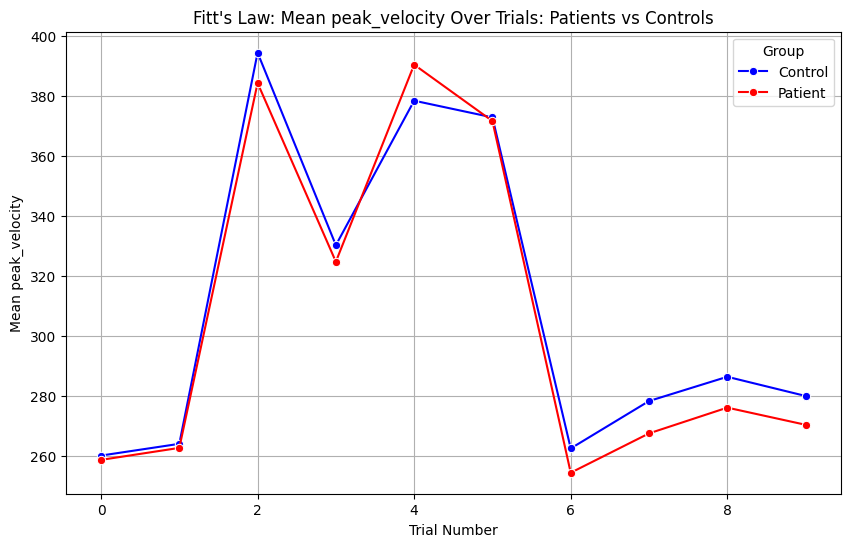

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the mean velocity per trial for each group
control_mean_velocity = saccades_control.groupby("trial_id")["peak_velocity"].mean().reset_index()
patient_mean_velocity = saccades_patient.groupby("trial_id")["peak_velocity"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plot controls
sns.lineplot(
    data=control_mean_velocity, 
    x="trial_id", 
    y="peak_velocity", 
    label="Control", 
    linestyle="-", 
    marker="o", 
    color="blue"
)

# Plot patients
sns.lineplot(
    data=patient_mean_velocity, 
    x="trial_id", 
    y="peak_velocity", 
    label="Patient", 
    linestyle="-", 
    marker="o", 
    color="red"
)

# Labels and title
plt.xlabel("Trial Number")
plt.ylabel("Mean peak_velocity")
plt.title("Fitt's Law: Mean peak_velocity Over Trials: Patients vs Controls")
plt.legend(title="Group")
plt.grid(True)
#plt.xlim(0,9)  # Set y-axis to start at 100

# Show plot
plt.show()

# Show plot
plt.show()

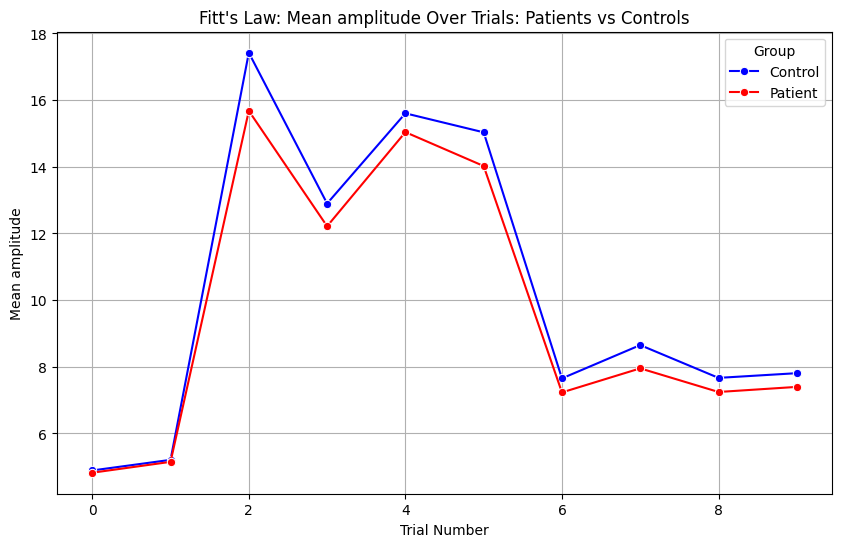

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the mean velocity per trial for each group
control_mean_amplitude = saccades_control.groupby("trial_id")["amplitude"].mean().reset_index()
patient_mean_amplitude = saccades_patient.groupby("trial_id")["amplitude"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plot controls
sns.lineplot(
    data=control_mean_amplitude, 
    x="trial_id", 
    y="amplitude", 
    label="Control", 
    linestyle="-", 
    marker="o", 
    color="blue"
)

# Plot patients
sns.lineplot(
    data=patient_mean_amplitude, 
    x="trial_id", 
    y="amplitude", 
    label="Patient", 
    linestyle="-", 
    marker="o", 
    color="red"
)

# Labels and title
plt.xlabel("Trial Number")
plt.ylabel("Mean amplitude")
plt.title("Fitt's Law: Mean amplitude Over Trials: Patients vs Controls")
plt.legend(title="Group")
plt.grid(True)
#plt.xlim(0,9)  # Set y-axis to start at 100

# Show plot
plt.show()
# Show plot
plt.show()

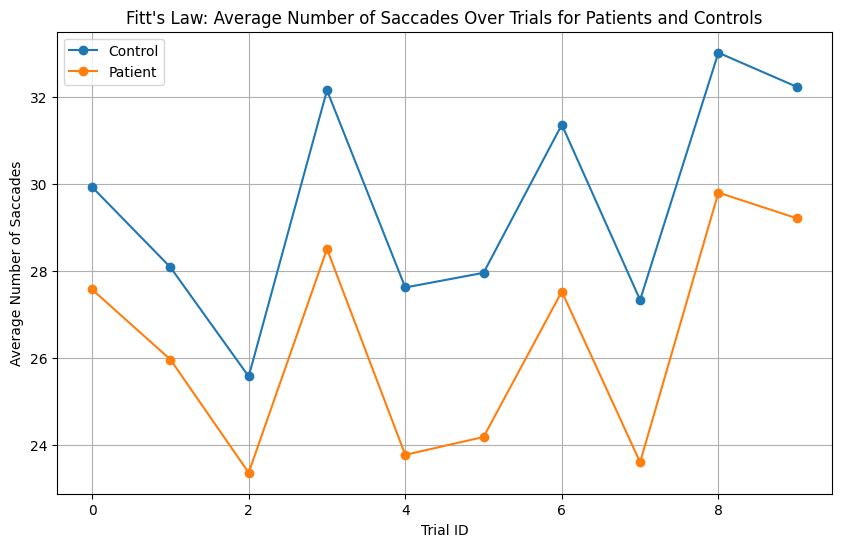

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Group by trial and participant to count saccades per trial
saccades_control_counts = saccades_control.groupby(["trial_id", "participant_id"]).size().groupby("trial_id").mean()
saccades_patient_counts = saccades_patient.groupby(["trial_id", "participant_id"]).size().groupby("trial_id").mean()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(saccades_control_counts.index, saccades_control_counts.values, label="Control", marker="o", linestyle="-")
plt.plot(saccades_patient_counts.index, saccades_patient_counts.values, label="Patient", marker="o", linestyle="-")

plt.xlabel("Trial ID")
plt.ylabel("Average Number of Saccades")
plt.title("Fitt's Law: Average Number of Saccades Over Trials for Patients and Controls")
plt.legend()
#plt.xlim(0,9)  # Set y-axis to start at 100
plt.grid(True)
plt.show()

In [52]:
from scipy.stats import ttest_ind

# Grouping the data over trials and participants
amplitude_patient = saccades_patient.groupby(["participant_id", "trial_id"])["amplitude"].mean()
amplitude_control = saccades_control.groupby(["participant_id", "trial_id"])["amplitude"].mean()

peak_velocity_patient = saccades_patient.groupby(["participant_id", "trial_id"])["peak_velocity"].mean()
peak_velocity_control = saccades_control.groupby(["participant_id", "trial_id"])["peak_velocity"].mean()

avg_velocity_patient = saccades_patient.groupby(["participant_id", "trial_id"])["average_velocity"].mean()
avg_velocity_control = saccades_control.groupby(["participant_id", "trial_id"])["average_velocity"].mean()

fixation_duration_patient = saccades_patient.groupby(["participant_id", "trial_id"])["duration"].mean()
fixation_duration_control = saccades_control.groupby(["participant_id", "trial_id"])["duration"].mean()

saccades_patient_total = saccades_patient.groupby(["participant_id", "trial_id"]).size()
saccades_control_total = saccades_control.groupby(["participant_id", "trial_id"]).size()

# Perform independent t-tests (Welch's t-test, assuming unequal variance)
stat_amplitude, pval_amplitude = ttest_ind(amplitude_patient, amplitude_control, equal_var=False)
print(f"Amplitude: t-statistic = {stat_amplitude:.4f}, p-value = {pval_amplitude:.4f}")

stat_peak_velocity, pval_peak_velocity = ttest_ind(peak_velocity_patient, peak_velocity_control, equal_var=False)
print(f"Peak Velocity: t-statistic = {stat_peak_velocity:.4f}, p-value = {pval_peak_velocity:.4f}")

stat_avg_velocity, pval_avg_velocity = ttest_ind(avg_velocity_patient, avg_velocity_control, equal_var=False)
print(f"Average Velocity: t-statistic = {stat_avg_velocity:.4f}, p-value = {pval_avg_velocity:.4f}")

stat_fixation_duration, pval_fixation_duration = ttest_ind(fixation_duration_patient, fixation_duration_control, equal_var=False)
print(f"Fixation Duration: t-statistic = {stat_fixation_duration:.4f}, p-value = {pval_fixation_duration:.4f}")

stat_total_saccades, pval_total_saccades = ttest_ind(saccades_patient_total, saccades_control_total, equal_var=False)
print(f"Total Number of Saccades: t-statistic = {stat_total_saccades:.4f}, p-value = {pval_total_saccades:.4f}")

Amplitude: t-statistic = -3.1384, p-value = 0.0017
Peak Velocity: t-statistic = -1.7374, p-value = 0.0826
Average Velocity: t-statistic = -2.4376, p-value = 0.0149
Fixation Duration: t-statistic = -4.7143, p-value = 0.0000
Total Number of Saccades: t-statistic = -7.7393, p-value = 0.0000
